<a href="https://colab.research.google.com/github/zxzhaixiang/MachineLearning_demo/blob/master/CollaborativeFiltering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Collaborated Filtering with PyTorch

In this notebook, we will be training a simple movie recommendation model based on collaborated filtering algorithm using neural network. We will be using the movielens-latest dataset. ML-latest is a 265MB movie rating dataset, containing 27,000,000 ratings applied to 58,000 movies by 280,000 users, as well as 1,100,000 tags. For simplicity, we will be using a dense subset of all the ratings to build the system.

This notebook can be run directly on Google Colab. It is highly recommended to use the Python 3 GPU runtime

## Download the Dataset and Import modules

In [0]:
# download ml dataset
import os
import zipfile
if (not os.path.exists('./ml-latest.zip')):
    !wget "http://files.grouplens.org/datasets/movielens/ml-latest.zip"
if (not os.path.isdir('./ml-latest')):
    zip_ref = zipfile.ZipFile('ml-latest.zip','r')
    zip_ref.extractall('ml-latest')
    zip_ref.close()

In [2]:
!pip install torchsummary
!pip install torchsummaryX

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
from IPython.display import HTML, display
import pickle
import random
import scipy.signal as sp_signal
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE
import scipy.stats

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torch.autograd import Variable
from torchvision import transforms

from torchsummary import summary
from torchsummaryX import summary as summaryX

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is ", device)

Device is  cuda


## Loading data and prepare data loader

In [0]:
class MovieLensData():
    '''
        prepare dataset for MovieLens 1M data
        
        INPUT
        folder_path: path of the folder that contains the MovieLens dataset
        seed:        seed for random generator
        OUPUT
        conventional dataset
    '''
    
    def __init__(self, folder_path='./', seed = 123):
        random.seed(seed)
        self.datapath = folder_path

        #load data into DataFrame
        self.rating_df, self.user_df, self.movie_df = self.loadRawData(self.datapath)
        
        #create u, m, r
        self.nM      = self.movie_df['movieId'].shape[0]
        self.nU      = self.user_df['userId'].shape[0]
        self.nR      = self.rating_df['rating'].unique().shape[0]
        #self.nInfo   = len(info_to_include)
        self.nRecord = self.rating_df['rating'].shape[0]
        
        self.U    = torch.tensor(self.rating_df['userId'].values,  dtype=torch.long).reshape(-1,1)
        self.M    = torch.tensor(self.rating_df['movieId'].values, dtype=torch.long).reshape(-1,1)
        self.R    = torch.tensor(self.rating_df['rating'].values, dtype=torch.float).reshape(-1,1)
        self.W    = torch.tensor(self.rating_df['rating_weight'].values, dtype = torch.float).reshape(-1,1)
        #self.INFO = torch.tensor(self.rating_df[info_to_include].values, dtype=torch.float).reshape(-1,len(info_to_include))
        
    def loadRawData(self, path):
        '''
          loadRawData loads ratings.csv and movies.csv
          Only highly active users and most rated movies are kept to
            1. reduce data sparsity
            2. reduce computation time
        '''
        print('loading raw rating data..',end='')
        rating_df = pd.read_csv(path+'ratings.csv')
        print('Done\n {} total rating record loaded\n'.format(rating_df.shape[0]))

        #aggregated by user
        rating_by_user_df = rating_df.groupby('userId', as_index=False).agg({'movieId':[('num_movie_rated','count')]})
        rating_by_user_df.columns.set_levels([item if item!='' else 'userId' for item in rating_by_user_df.columns.levels[1]],level=1,inplace=True)
        rating_by_user_df.columns = rating_by_user_df.columns.droplevel(0) #drop first level column name (old column name before aggregation)

        print('{} users found'.format(rating_by_user_df.shape[0]))
        print('Raw Rating information aggregated by user\n {}\n'.format(rating_by_user_df.describe()))

        rating_by_user_df = rating_by_user_df[rating_by_user_df['num_movie_rated']>=1500].reset_index(drop=True)

        print('{} users kept'.format(rating_by_user_df.shape[0]))
        print('rating information\n {}\n'.format(rating_by_user_df.describe()))

        rated_userIds = rating_by_user_df['userId'].unique()
        userId_old2new = dict(zip(rated_userIds,list(range(len(rated_userIds)))))

        #remove rating record of the deleted userId
        rating_df = rating_df[rating_df['userId'].isin(rated_userIds)].reset_index(drop=True)
        print('{} rating information kept after inactive userIds removed\n'.format(rating_df.shape[0]))

        #aggregated by movie
        rating_by_movie_df = rating_df.groupby('movieId', as_index = False).agg({'userId': [('num_rating', 'count')]})
        rating_by_movie_df.columns.set_levels([item if item!='' else 'movieId' for item in rating_by_movie_df.columns.levels[1]],level=1,inplace=True)
        rating_by_movie_df.columns = rating_by_movie_df.columns.droplevel(0)#drop first level column name (old column name before aggregation)

        nMovie_raw = rating_by_movie_df.shape[0]

        print('{} movies found'.format(rating_by_movie_df.shape[0]))
        print('Raw rating information aggregated by movie\n {}\n'.format(rating_by_movie_df.describe()))

        rating_by_movie_df = rating_by_movie_df[rating_by_movie_df['num_rating']>80].reset_index(drop=True)

        rated_movieIds = rating_by_movie_df['movieId'].unique()
        movieId_old2new = dict(zip(rated_movieIds,list(range(len(rated_movieIds)))))

        #remove rating record of the deleted movieId
        rating_df = rating_df[rating_df['movieId'].isin(rated_movieIds)].reset_index(drop=True)
        print('{} movies kept'.format(rating_by_movie_df.shape[0]))
        print('{} rating information kept after rarely rated movies are removed\n'.format(rating_df.shape[0]))

        rating_df['userId'] = rating_df['userId'].apply(lambda x:userId_old2new[x])
        rating_df['movieId'] = rating_df['movieId'].apply(lambda x:movieId_old2new[x])

        rating_count  = rating_df['rating'].value_counts()
        rating_weight = 1./rating_count.values
        rating2weight = dict(zip(rating_count.index, rating_weight))

        rating_df['rating_weight'] = rating_df['rating'].apply(lambda r: rating2weight[r])

        user_df = rating_df.groupby('userId', as_index=False).agg({
                      'movieId': [('num_movie_rated','count')],
                      'rating': [('user_ave_rating','mean'),('user_std_rating','std')]}).fillna(0)
        user_df.columns.set_levels([item if item!='' else 'userId' for item in user_df.columns.levels[1]],level=1,inplace=True)
        user_df.columns = user_df.columns.droplevel(0) #drop first level column name (old column name before aggregation)

        rating_by_movie_df = rating_df.groupby('movieId', as_index = False).agg({
                    'userId': [('num_rating', 'count')],
                    'rating': [('movie_ave_rating','mean'),('movie_std_rating', 'std')]})
        rating_by_movie_df.columns.set_levels([item if item!='' else 'movieId' for item in rating_by_movie_df.columns.levels[1]],level=1,inplace=True)
        rating_by_movie_df.columns = rating_by_movie_df.columns.droplevel(0)#drop first level column name (old column name before aggregation)
        
        print('{} rating record found by {} users for {} movies. \n Data sparsity = {}%\n'.format(
          rating_df.shape[0], rating_by_user_df.shape[0], rating_by_movie_df.shape[0],
          100-rating_df.shape[0]*100.0/(rating_by_user_df.shape[0]*rating_by_movie_df.shape[0])))


        movie_df = pd.read_csv(path+'movies.csv')
        movie_df = movie_df[movie_df['movieId'].isin(rated_movieIds)].reset_index(drop=True)
        movie_df['movieId'] = movie_df['movieId'].apply(lambda x: movieId_old2new[x])

        movie_df['title'] = movie_df['title'].apply(lambda x: x.strip())
        movie_df['year'] = movie_df['title'].apply(lambda x: 2000 if x[-1]!=')' else int(x[-5:-1]))
        movie_df['title'] = movie_df['title'].apply(lambda x: x if x[-1]!=')' else x[:-7])

        genres = {a for s in movie_df['genres'] for a in s.split('|')}
        print('{} number of movie genres exist. They are '.format(len(genres)), genres)
        for genre in genres:
            movie_df[genre] = movie_df['genres'].apply(lambda x: genre in x).astype(int)
        self.movie_genres = genres
        movie_df.drop(['genres'],axis=1, inplace = True)

        movie_df = movie_df.merge(rating_by_movie_df, how='left',on='movieId')

        return rating_df, user_df, movie_df

In [7]:
ML_Data = MovieLensData(folder_path='./ml-latest/ml-latest/')

loading raw rating data..Done
 27753444 total rating record loaded

283228 users found
Raw Rating information aggregated by user
               userId  num_movie_rated
count  283228.000000    283228.000000
mean   141614.500000        97.989761
std     81761.025358       212.760722
min         1.000000         1.000000
25%     70807.750000        15.000000
50%    141614.500000        30.000000
75%    212421.250000        95.000000
max    283228.000000     23715.000000

923 users kept
rating information
               userId  num_movie_rated
count     923.000000       923.000000
mean   143187.224269      2245.813651
std     82809.158451      1124.082903
min       214.000000      1500.000000
25%     71770.000000      1672.000000
50%    142040.000000      1932.000000
75%    216857.500000      2446.500000
max    283195.000000     23715.000000

2072886 rating information kept after inactive userIds removed

46428 movies found
Raw rating information aggregated by movie
              movieId  

At the end, we select a subset of all ratings containing most rated movies rated by most active users. A total of 6000+ movies are kept, rated by about 1000 users with a total of 1.6M rating. The sparsity is 71%, which is much higher than the origianl dataset

### Prepare data loader for training and validation

In [0]:
batch_size = 4096
validation_split = .2
shuffle_dataset = True
random_seed = 42

In [0]:
dataset_size = ML_Data.nRecord
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_idx, val_idx = indices[split:], indices[:split]

Turns out that most movies were given rating 3-4. Also seems that people like to give integer number of rating, i.e., 3, or 4, instead of 3.5. The data is imbalanced (not significantly through). We hence oversample the underpresented low rating movies and 5-star movies to bring all rating balanced. This step is optional though as the dataset is not extremely imbalanced.

In [0]:
ros = RandomOverSampler(random_state=random_seed)
train_idx_resampled, _ = ros.fit_resample(np.array(train_idx).reshape(-1,1), (ML_Data.R[train_idx].numpy()*2).reshape(-1).astype(int))
train_idx_resampled = list(train_idx_resampled.reshape(-1))

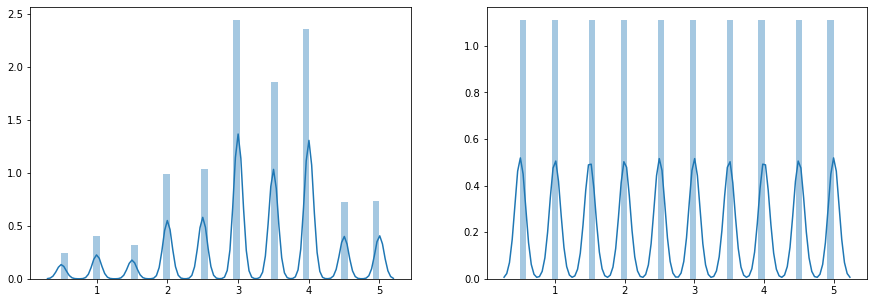

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(ML_Data.R[train_idx])
plt.subplot(122)
sns.distplot(ML_Data.R[train_idx_resampled])

In [12]:
print('Check if resampled indices covers all the original indices: {}'.format(set(train_idx)==set(train_idx_resampled)))

Check if resampled indices covers all the original indices: True


In [0]:
train_dataset = torch.utils.data.TensorDataset(
    ML_Data.U[train_idx_resampled], ML_Data.M[train_idx_resampled], ML_Data.R[train_idx_resampled])

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle = True)

In [0]:
val_dataset = torch.utils.data.TensorDataset(
    ML_Data.U[val_idx], ML_Data.M[val_idx], ML_Data.R[val_idx])
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle = True)


## Quick Data Visualization

Text(0.5, 1.0, 'Distribution of movie rating std')

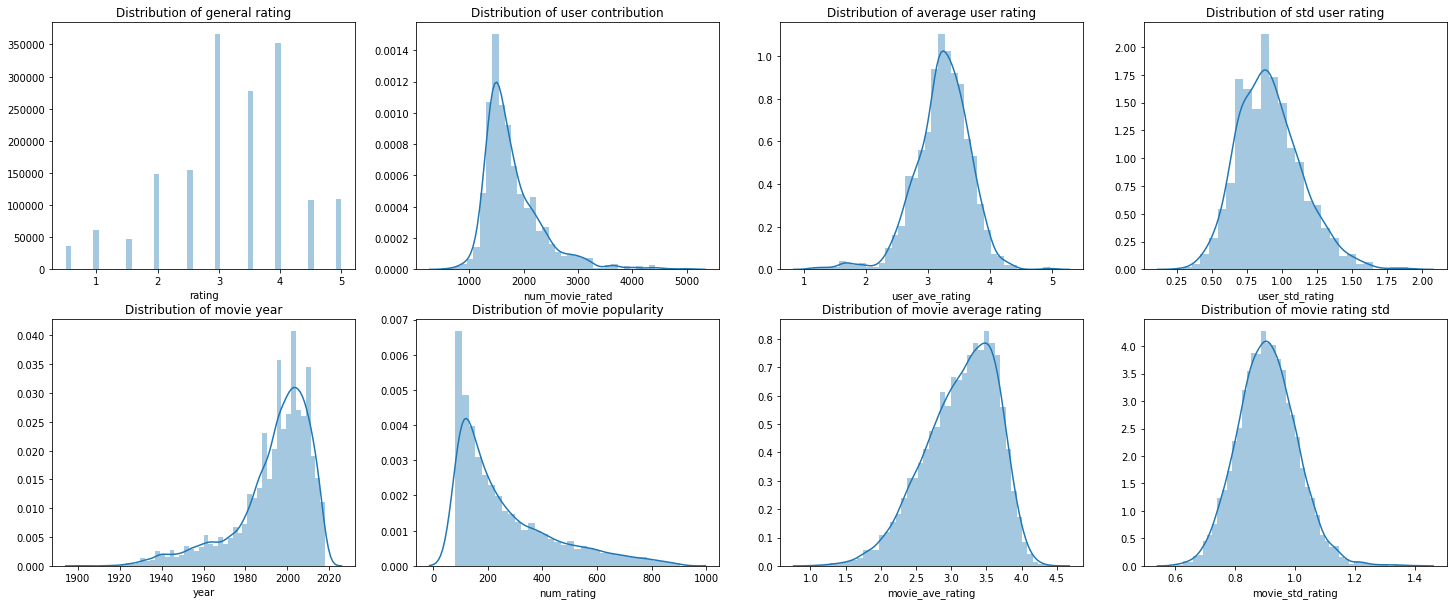

In [15]:
plt.figure(figsize=(25,10))
plt.subplot(241)
sns.distplot(ML_Data.rating_df['rating'], kde=False)
plt.title('Distribution of general rating')

plt.subplot(242)
sns.distplot(ML_Data.user_df['num_movie_rated'])
plt.title('Distribution of user contribution')

plt.subplot(243)
sns.distplot(ML_Data.user_df['user_ave_rating'])
plt.title('Distribution of average user rating')

plt.subplot(244)
sns.distplot(ML_Data.user_df['user_std_rating'])
plt.title('Distribution of std user rating')

plt.subplot(245)
sns.distplot(ML_Data.movie_df['year'])
plt.title('Distribution of movie year')

plt.subplot(246)
sns.distplot(ML_Data.movie_df['num_rating'])
plt.title('Distribution of movie popularity')

plt.subplot(247)
sns.distplot(ML_Data.movie_df['movie_ave_rating'])
plt.title('Distribution of movie average rating')

plt.subplot(248)
sns.distplot(ML_Data.movie_df['movie_std_rating'])
plt.title('Distribution of movie rating std')



## Build model

In [0]:
class NCF(nn.Module):
    def __init__(self, config):
        super(NCF, self).__init__()
        self.config = config
        self.user_dim = config['nUsers']
        self.item_dim = config['nItems']        
        self.u_latent_dim = config['user_latent_dim']
        self.i_latent_dim = config['item_latent_dim']
        
        self.user_embedding = nn.Embedding(self.user_dim, self.u_latent_dim, 
                                           max_norm=1, scale_grad_by_freq = True)
        
        self.item_embedding = nn.Embedding(self.item_dim, self.i_latent_dim,
                                           max_norm=1, scale_grad_by_freq = True)
        
        self.cos_sim = nn.CosineSimilarity(dim=2, eps=1e-6)
        
    def forward(self, user_id, item_id):
        
        user_em = self.user_embedding(user_id)
        item_em = self.item_embedding(item_id)
        return self.cos_sim(user_em,item_em)*5
        

In [17]:
config = {'nUsers': ML_Data.nU, 'nItems': ML_Data.nM, 
          'user_latent_dim': 128, 'item_latent_dim': 128}
print(config)

{'nUsers': 923, 'nItems': 6335, 'user_latent_dim': 128, 'item_latent_dim': 128}


In [0]:
CF = NCF(config).to(device)

In [0]:
CF_criterion = nn.MSELoss()
CF_optimizer = torch.optim.Adam(CF.parameters(), lr = 0.002, betas = (0.5, 0.999))

In [0]:
for i,(users, movies, ratings) in enumerate(train_loader):
    break

In [21]:
with torch.no_grad():
    dummy_userId = torch.LongTensor(np.zeros((5,1))).to(device)
    dummy_movieId = torch.LongTensor(np.zeros((5,1))).to(device)
    print(CF(dummy_userId, dummy_movieId))

tensor([[0.0658],
        [0.0658],
        [0.0658],
        [0.0658],
        [0.0658]], device='cuda:0')


In [22]:
summaryX(CF,dummy_userId,dummy_movieId)

                 Kernel Shape Output Shape    Params Mult-Adds
Layer                                                         
0_user_embedding   [128, 923]  [5, 1, 128]  118.144k  118.144k
1_item_embedding  [128, 6335]  [5, 1, 128]   810.88k   810.88k
2_cos_sim                   -       [5, 1]         -         -
---------------------------------------------------------------
                        Totals
Total params          929.024k
Trainable params      929.024k
Non-trainable params       0.0
Mult-Adds             929.024k


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_user_embedding,"[128, 923]","[5, 1, 128]",118144.0,118144.0
1_item_embedding,"[128, 6335]","[5, 1, 128]",810880.0,810880.0
2_cos_sim,-,"[5, 1]",NaN,NaN


## Training

In [0]:
class progress():
    def __init__(self,max = 100):
        self.mrange = max
        self.pbar = display(self.progress(0,M=self.mrange, loss=0), display_id = True)

    def update(self, i, loss=0):
        self.pbar.update(self.progress(i,M=self.mrange, loss=loss))
    
    def progress(self, value, loss=0, M=100):
        return HTML("""Training Mini Batch [{value}/{M}] Loss={loss:0.5f} <progress
                value='{value}'
                max='{M}',
                style='width: 80%'
            >
                90
            </progress>
              """.format(value=value,M=M,loss=loss))

In [0]:
train_losses = []
val_losses = []
train_losses_epoch = []
val_losses_epoch = []

In [25]:
nBatch_train = train_loader.__len__()
nBatch_val = val_loader.__len__()

print('{} mini-batches in training dataset, {} mini-batches in validation dataset'.format(nBatch_train, nBatch_val))

715 mini-batches in training dataset, 82 mini-batches in validation dataset


In [0]:
epoch_num = 5

In [0]:
def lr_schedular(optimizer, epoch):
    if(epoch<10):
        lr = 0.001
    elif(epoch<20):
        lr = 0.0005
    elif (epoch<30):
        lr = 0.00025
    else:
        lr = 0.0001

    for param_group in optimizer.param_groups:
        param_group['lr']=lr

    return optimizer

Training epoch 0/5


epoch[0/5], train loss = 4.537002358486602, val loss = 0.8464733543919354


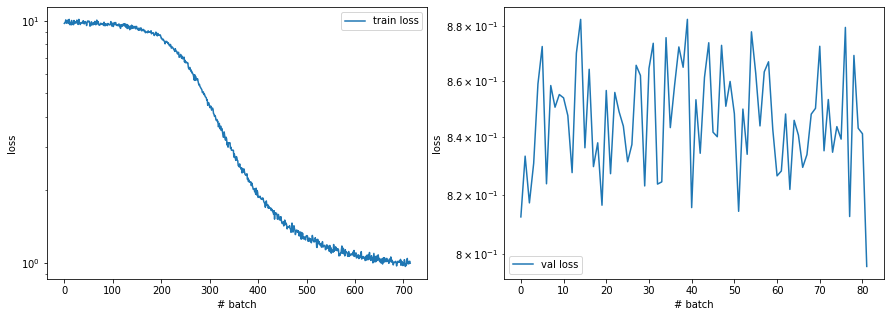

Training epoch 1/5


epoch[1/5], train loss = 0.842497002078103, val loss = 0.7249176618529529
Training epoch 2/5


epoch[2/5], train loss = 0.6841893691283006, val loss = 0.6700674578910921
Training epoch 3/5


epoch[3/5], train loss = 0.6168437828550806, val loss = 0.6472518909268263
Training epoch 4/5


epoch[4/5], train loss = 0.5886486240200229, val loss = 0.6335361461813857


In [28]:
for epoch in range(epoch_num):
    print('Training epoch {}/{}'.format(epoch, epoch_num))
    pbar = progress(train_loader.__len__())
    
    train_loss = 0
    val_loss = 0
    tmp_loss = 0
    
    CF_optimizer = lr_schedular(CF_optimizer, epoch)

    for i,(users, movies, ratings) in enumerate(train_loader):
        pbar.update(i+1, tmp_loss)
        U, I, R = users.to(device), movies.to(device), ratings.to(device)
        rhat = CF(U,I)
        
        loss = CF_criterion(rhat, R)
        
        CF_optimizer.zero_grad()
        
        loss.backward()
        
        CF_optimizer.step()
        
        tmp_loss = loss.item()
        train_loss += loss.item()
        train_losses.append(loss.item())

    train_loss/=nBatch_train
    train_losses_epoch.append(train_loss)
    
    for i, (u,m,r) in enumerate(val_loader):
        U, I, R = u.to(device), m.to(device), r.to(device)
        rhat = CF(U,I)
        loss = CF_criterion(rhat,R)
        val_loss += loss.item()
        val_losses.append(loss.item())
        
    val_loss/=nBatch_val
    val_losses_epoch.append(val_loss)
    
    print('epoch[{}/{}], train loss = {}, val loss = {}'.
         format(epoch, epoch_num, train_loss, val_loss))
    
    if (epoch%5==0):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(train_losses, label='train loss')
        plt.xlabel('# batch'), plt.ylabel('loss'), plt.legend(), plt.yscale('log')
        plt.subplot(122)
        plt.plot(val_losses, label='val loss')
        plt.xlabel('# batch'), plt.ylabel('loss'), plt.legend(), plt.yscale('log')
        plt.show()

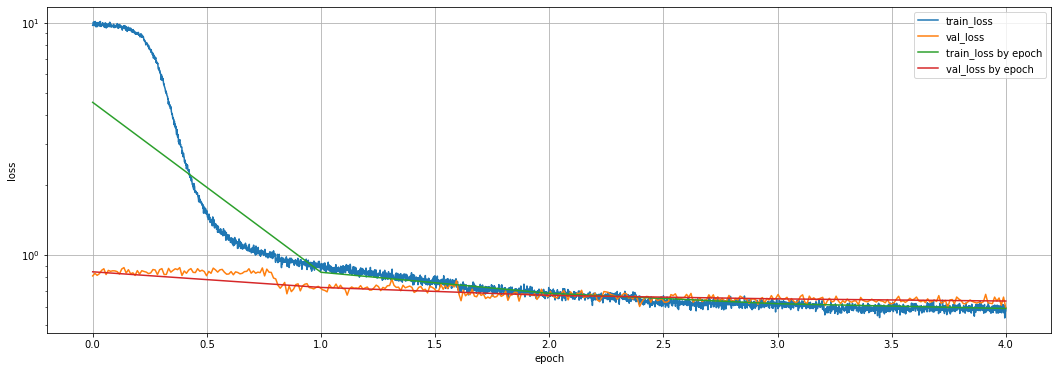

In [29]:
plt.figure(figsize=(18,6))

plt.plot(np.linspace(0,epoch_num-1, len(train_losses)),train_losses,label='train_loss')
plt.plot(np.linspace(0,epoch_num-1, len(val_losses)),val_losses,label='val_loss')
plt.plot(train_losses_epoch,label='train_loss by epoch')
plt.plot(val_losses_epoch,label='val_loss by epoch')
plt.yscale('log')
plt.legend(),plt.xlabel('epoch'), plt.ylabel('loss')
plt.grid(True)
#plt.ylim([0.01,0.05])

### Evaluate the model on validation dataset

In [30]:
r_real = []
r_pred = []


for i, (u,m,r) in enumerate(val_loader):
    U, I= u.to(device), m.to(device)
    rhat = CF(U,I)
    r_real+=list(r.detach().cpu().numpy().reshape(-1))
    r_pred+=list(rhat.detach().cpu().numpy().reshape(-1))    
    if(i%20==0):
        print('{}/{}'.format(i,nBatch_val))

0/82
20/82
40/82
60/82
80/82


In [0]:
r_real = np.array(r_real) #, dtype=np.int)
r_pred = np.array(r_pred) #, dtype=np.int)
e = r_pred - r_real

In [32]:
r_pearson = scipy.stats.pearsonr(r_real, r_pred)[0]
r_spearman = scipy.stats.spearmanr(r_real, r_pred).correlation
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_real, r_pred)

print('average error = {}, std = {}'.format(e.mean(), e.std()))
print('mae = {}'.format(np.abs(e).mean()))
print('rmse = {}'.format(np.sqrt(np.square(e).mean())))

print('slope={}, r2={}'.format(slope, r_value))
print('pearson = {}, spearman = {}'.format(r_pearson, r_spearman))

average error = -0.21351011097431183, std = 0.7670696973800659
mae = 0.6129580140113831
rmse = 0.7962301969528198
slope=0.5412893060348352, r2=0.6820701863842876
pearson = 0.6820701863842872, spearman = 0.6590979422234602


(Text(0.5, 0, 'predict error'), Text(0, 0.5, 'count'))

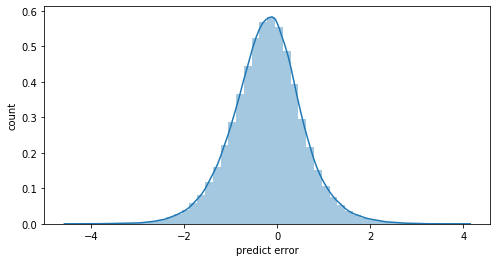

In [33]:
plt.figure(figsize=(8,4))
sns.distplot(r_pred-r_real, kde=True)
plt.xlabel('predict error'), plt.ylabel('count')

In [0]:
real = r.view(-1).detach().cpu().numpy()
pred = rhat.view(-1).detach().cpu().numpy()
users = U.detach().cpu().numpy().reshape(-1)
movies = I.detach().cpu().numpy().reshape(-1)
pd_df = pd.DataFrame({'real': real,'pred':pred, 'userId': users, 'movieId': movies})
pd_df = pd_df.merge(ML_Data.movie_df, how='left', on='movieId')
pd_df = pd_df.merge(ML_Data.user_df, how='left', on='userId')
pd_df = pd_df.drop(columns = ML_Data.movie_genres)

In [35]:
pd_df.head(50)

,real,pred,userId,movieId,title,year,num_rating,movie_ave_rating,movie_std_rating,num_movie_rated,user_ave_rating,user_std_rating
0,4.0,3.904933,587,1004,"Fast, Cheap & Out of Control",1997,144,3.475694,1.038305,1520,3.624013,0.821203
1,3.0,3.135808,455,32,Babe,1995,711,3.517581,1.046476,1808,3.176438,0.498596
2,2.5,3.526109,725,321,"Hudsucker Proxy, The",1994,549,3.545537,0.886704,1397,3.728704,0.784739
3,3.0,3.002308,385,1334,Topaz,1969,108,2.893519,0.834566,2231,3.667862,0.897152
4,2.5,3.499477,193,4387,Madagascar,2005,431,3.045244,0.897500,1382,3.369030,0.616744
5,2.5,2.928895,175,1400,My Cousin Vinny,1992,639,3.500000,0.814735,2179,2.643414,1.075957
6,3.0,2.836786,470,2616,Alice,1990,120,3.200000,0.863353,1348,3.178412,1.059073
7,3.5,3.140457,166,2569,Shrek,2001,845,3.629586,0.929417,1332,3.252252,1.025682
8,4.0,3.154223,631,4804,Cashback,2006,218,3.229358,0.876030,1757,2.900683,1.094072
9,3.0,3.008736,32,955,Men in Black (a.k.a. MIB),1997,879,3.468146,0.848493,1324,2.959592,0.977482


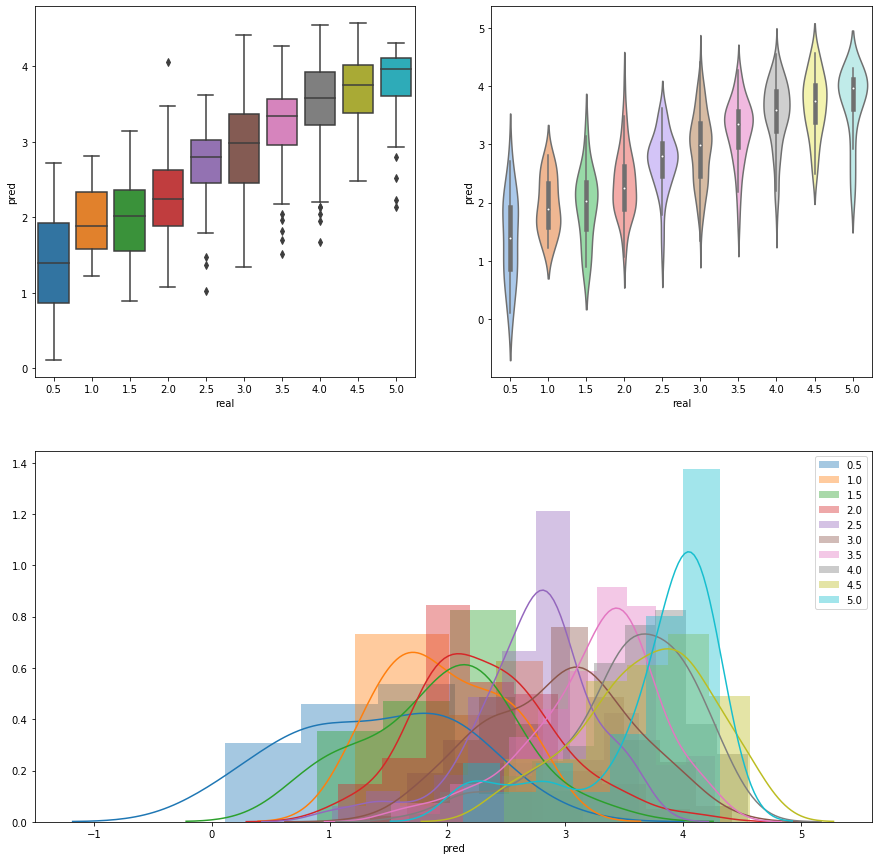

In [37]:
plt.figure(figsize=(15,15))
plt.subplot(221)
sns.categorical.boxplot(x="real", y="pred", data=pd_df)

plt.subplot(222)
sns.categorical.violinplot(x="real", y="pred", split=True,  data=pd_df, palette="pastel")

plt.subplot(2,2,(3,4))
rs = list(pd_df['real'].unique())
rs.sort()
for r in rs:
    sns.distplot(pd_df['pred'][pd_df['real']==r], label=str(int(r*2)/2))
plt.legend()

In [0]:
Movie_Em = CF.item_embedding.weight.data.detach().cpu().numpy()

Text(0.5, 1.0, 'Distribution of length of movie embedding vectors')

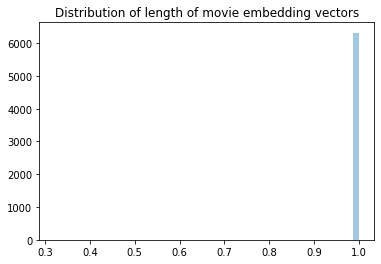

In [39]:
L = np.linalg.norm(Movie_Em,axis=1,keepdims=True)
sns.distplot(L,kde=False)
plt.title('Distribution of length of movie embedding vectors')

#### Visualize Movies in latent space

Text(0, 0.5, 'Movie average rating')

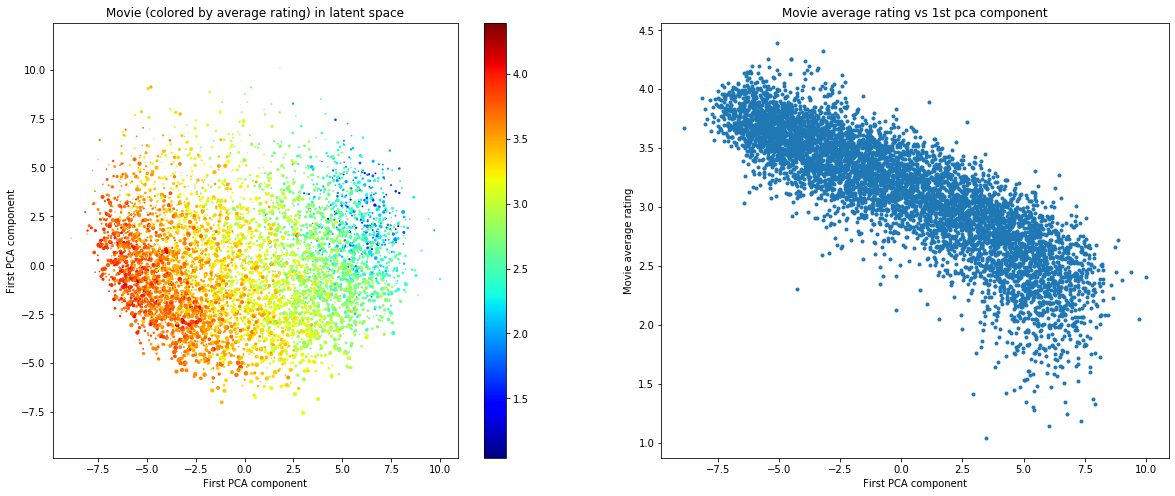

In [40]:
pca = decomposition.PCA(n_components = 5)
M_std = StandardScaler().fit_transform(Movie_Em)
M_pca = pca.fit_transform(M_std)

plt.figure(figsize=(20,8))
plt.subplot(121)
ss = (ML_Data.movie_df['num_rating'].values - ML_Data.movie_df['num_rating'].min())/60
plt.scatter(M_pca[:,0], M_pca[:,1], c = ML_Data.movie_df['movie_ave_rating'].values, s = ss, cmap='jet')
plt.colorbar()
plt.axis('equal')
plt.xlabel('First PCA component')
plt.ylabel('First PCA component')
plt.title('Movie (colored by average rating) in latent space')
plt.subplot(122)
plt.plot(M_pca[:,0], ML_Data.movie_df['movie_ave_rating'],'.')
plt.title('Movie average rating vs 1st pca component')
plt.xlabel('First PCA component')
plt.ylabel('Movie average rating')

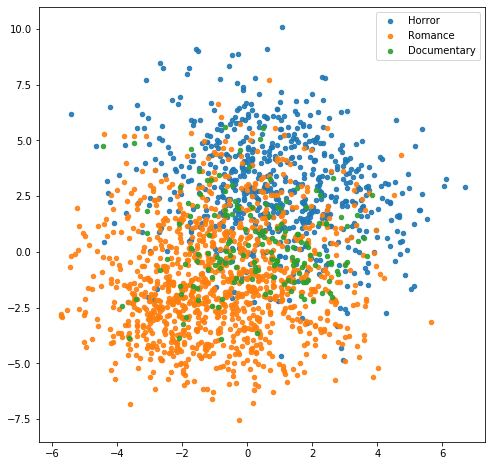

In [41]:
plt.figure(figsize=(8,8))
#for g in ML_Dataset.movie_genres:
for g in ['Horror','Romance','Documentary']:
    ind = ML_Data.movie_df.index[ML_Data.movie_df[g] == 1].tolist()
    plt.scatter(M_pca[ind,2], M_pca[ind,1],label=g,s=20, alpha=0.9)
plt.legend()


(-6.5803523, 5.3714886)

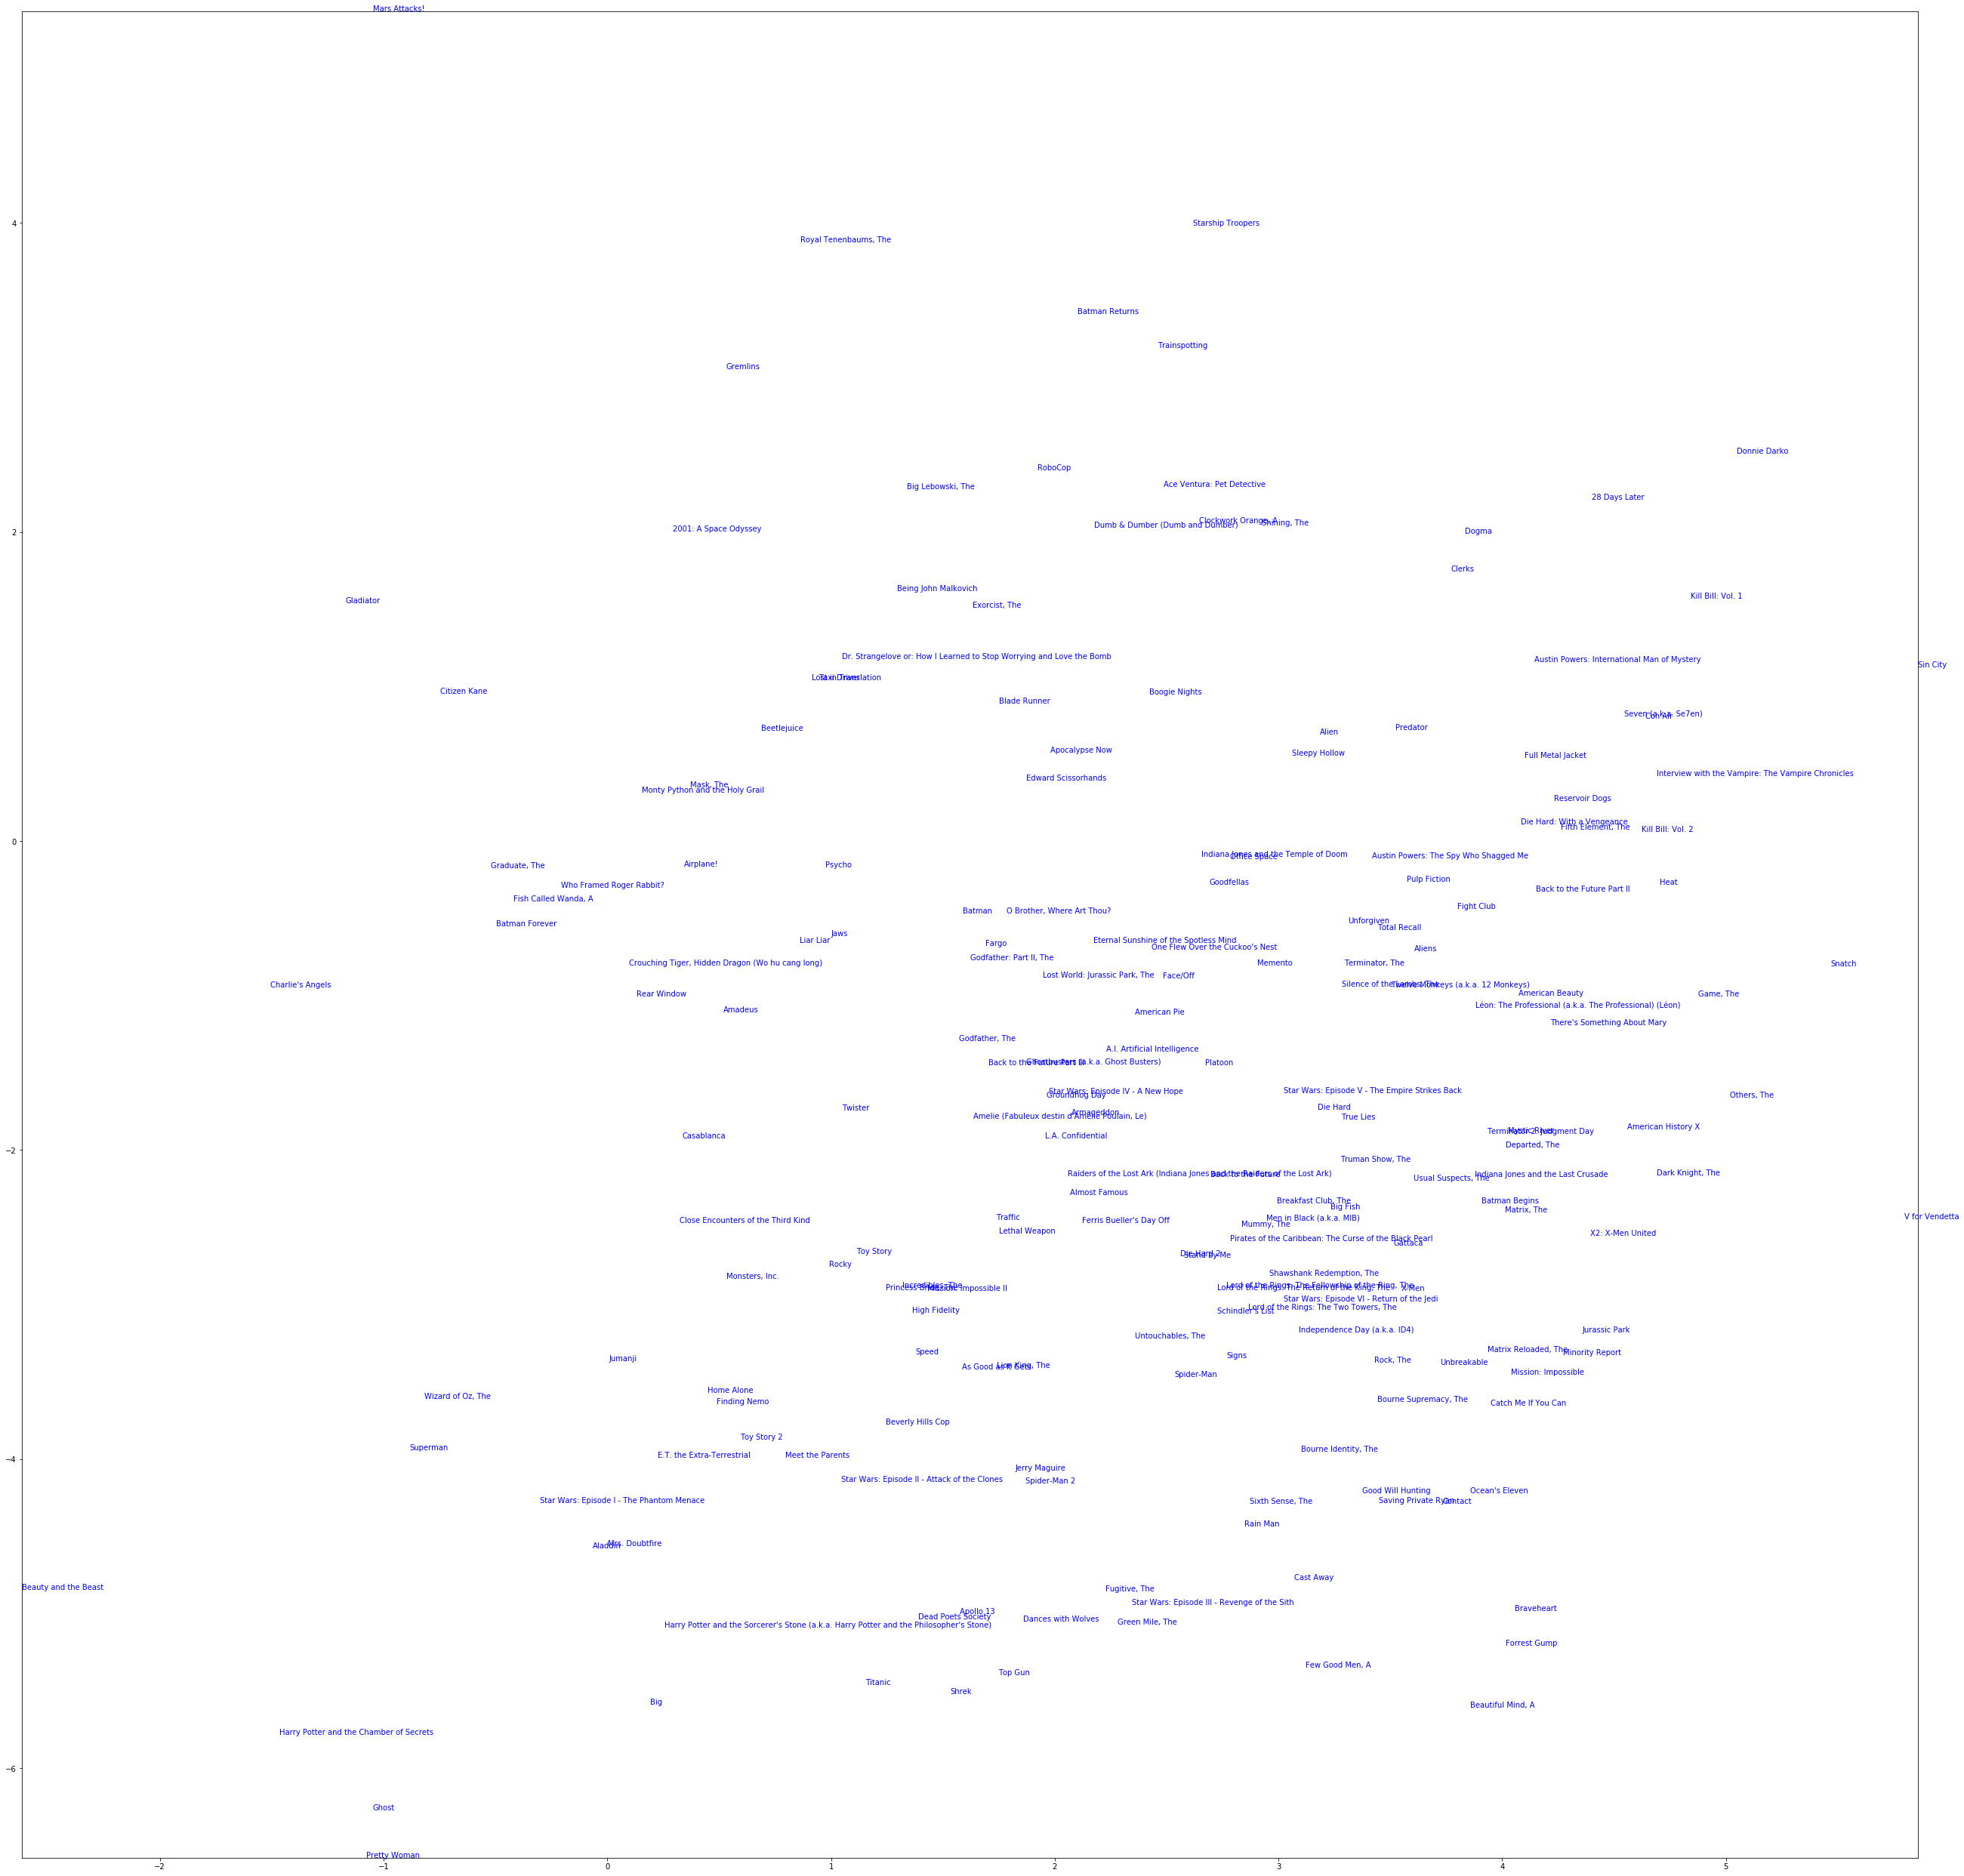

In [42]:
TopMovies_id = ML_Data.movie_df['num_rating'].nlargest(200).index.values

plt.figure(figsize=(45,45))

xs = []
ys = []

for i in TopMovies_id:
    t = ML_Data.movie_df['title'][i]
    x,y = M_pca[i,2], M_pca[i,1]
    xs+=[x]
    ys+=[y]
    plt.text(x,y,t,color='b', fontsize=10)

plt.xlim([min(xs),max(xs)])
plt.ylim([min(ys),max(ys)])

#### Find most similar movies in latent space

In [0]:
Movie_Em = Movie_Em/L

In [0]:
Movie_S = np.matmul(Movie_Em, Movie_Em.T)

In [45]:
for i in range(50):
    movie_id = TopMovies_id[i]
    t = ML_Data.movie_df['title'][movie_id]
    print('Movie:'+t)
    
    tmp_S = Movie_S[movie_id]
    tmp_ids = tmp_S.argsort()[::-1]
    n = 0
    for tmp_id in tmp_ids[1:]:
        if(ML_Data.movie_df['movie_ave_rating'][tmp_id]>2.5):
            t = ML_Data.movie_df['title'][tmp_id]
            print('  ',t)
            n+=1
        if (n>10):
            break
    print()

Movie:Matrix, The
   Lord of the Rings: The Fellowship of the Ring, The
   Star Wars: Episode V - The Empire Strikes Back
   Terminator 2: Judgment Day
   Léon: The Professional (a.k.a. The Professional) (Léon)
   Lord of the Rings: The Two Towers, The
   Lord of the Rings: The Return of the King, The
   Dark Knight, The
   Inception
   Star Wars: Episode VI - Return of the Jedi
   Shawshank Redemption, The
   Star Wars: Episode IV - A New Hope

Movie:Silence of the Lambs, The
   Aliens
   Alien
   Star Wars: Episode V - The Empire Strikes Back
   Die Hard
   Terminator 2: Judgment Day
   One Flew Over the Cuckoo's Nest
   Terminator, The
   Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark)
   Goodfellas
   Usual Suspects, The
   Pulp Fiction

Movie:Back to the Future
   Die Hard
   Terminator 2: Judgment Day
   Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark)
   Star Wars: Episode V - The Empire Strikes Back
   Aliens
   Groundhog Day
   Te